# Mellin Moments fits

In [1]:
import torch as tr

if tr.backends.mps.is_available():
    device = tr.device("mps")
    x = tr.ones(1, device=device)
    print (x)
elif tr.cuda.is_available():
    device = tr.device("cuda")
    x = tr.ones(1, device=device)
    print (x)
else:
    print ("MPS or cuda device not found.")

from GP import *
import torch as tr
import numpy as np
import statistics as st
from puwr import *


import scipy.integrate as integrate
from torch.special import gammaln
#from orthogonal_poly import legendre_01

from torch.autograd.functional import hessian

import scipy.integrate as integrate

import h5py as h5

# import all packages and set plots to be embedded inline
import numpy as np 
import datetime
from scipy.optimize import minimize 
from scipy import special 
from scipy.optimize import Bounds 
from scipy.linalg import cho_solve 
#from pyDOE import lhs 
import time
#load all the Models and Kernels
from functions import *
import matplotlib.pyplot as plt
import matplotlib as mpl


import os
os.environ["PATH"] = "/sciclone/home/yacahuanamedra/texlive/bin/x86_64-linux:" + os.environ["PATH"]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts}')
import pickle


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

MPS or cuda device not found.


In [2]:
def Modeldefmell(ITD,modelname,kernelname,nugget,device,mode,ID,test,grid,Nx):
    fits_comb=[]
    mean,sigma,config,mod,ker,modfunc,kerfunc,device,mode,ID,x_grid,lab = arguments(modelname,kernelname,nugget,device,mode,ID,grid,Nx)
    nu,rMj,rMe,rM = get_data(ITD)
    now = datetime.datetime.now()
    print("#################Define the model###########################")
    print ("Current date and time :", now.strftime("%Y-%m-%d %H:%M:%S"))
    print("GP specifications \n Sampling or training: "+mode+"\n model: "+modelname+"\n kernel: "+kernelname+" nugget: "+ nugget+"\n Ioffe time Distribution: "+ITD+"(M)",
          "\n mean =",mean,"\n sigma =",sigma,"\n prior dist =",config,"\n model init =",mod,"\n kernel init =",ker,"\n device =",device,"\n mode =",mode,"\n ID =",ID)
    #print("0=gaussian, 1=lognormal, 2=expbeta")
    for i in range(0,12):
        x_gri0,V0,Y0,Gamma0 = preparedata(i,nu,rMj,rMe,rM,x_grid,ITD=ITD)
        myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z={i+1}a",nugget=nugget,device=device,ITD=ITD,labels=lab,kernelname=kernelname,modelname=modelname,Pd=modfunc, Ker=kerfunc,Pd_args=mod,Ker_args=ker)
        myGP0.prior2ndlevel(mode,0.99,mean=mean,sigma=sigma,prior_mode=config)
        fits_comb.append(myGP0)
        #print(fits_comb[i].name, "done")
    if ITD=="Re" and test=="mock":
        numax=[4,10,25]
        for j in range(0,3):
            x_gri0,V0,Y0,Gamma0 = preparemockdata1(numax[j]+1,numax[j],x_grid,ITD)
            myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z=mock({numax[j]})",nugget=nugget,device=device,ITD=ITD,labels=lab,kernelname=kernelname,modelname=modelname,Pd=modfunc, Ker=kerfunc,Pd_args=mod,Ker_args=ker)
            myGP0.prior2ndlevel(mode,0.99,mean=mean,sigma=sigma,prior_mode=config)
            fits_comb.append(myGP0)
            #print(fits_comb[-1].name, "done")
    elif test=="NNPDF":
        if ITD=="Re":
            MMM='real'
        elif ITD=="Im":
            MMM='imag'
        for i in [4,10,25]:
            datanu4 = np.loadtxt('NNPDF/NNPDF40_nnlo_as_01180_1000_itd_'+MMM+'_numax'+str(i)+'.dat',dtype=np.float64)
            x_gri0,V0,Y0,Gamma0 = NNPDFdata(datanu4,x_grid,[1e-11,1e-12,1e-13],[1e-5,1e-5],ITD)
            myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z=NNPDF({i})",nugget=nugget,device=device,ITD=ITD,labels=lab,kernelname=kernelname,modelname=modelname,Pd=modfunc, Ker=kerfunc,Pd_args=mod,Ker_args=ker)
            myGP0.prior2ndlevel(mode,0.99,mean=mean,sigma=sigma,prior_mode=config)
            fits_comb.append(myGP0)
            print(fits_comb[-1].name, "done")
    return fits_comb

In [3]:
pdfminus = np.loadtxt('NNPDF/NNPDF40_nnlo_as_01180_1000_pdf_minus.dat',dtype=np.float64)
pdfplus = np.loadtxt('NNPDF/NNPDF40_nnlo_as_01180_1000_pdf_plus.dat',dtype=np.float64)
covmin=np.cov(pdfminus[:,1:])
covplus=np.cov(pdfplus[:,1:])
covmindiag=np.diag(covmin)
covplusdiag=np.diag(covplus)
meanplus=pdfplus[:,1:].mean(axis=1)
meanminus=pdfminus[:,1:].mean(axis=1)

x_grid = generategrid(256,"log_lin")
Nx=x_grid.shape[0]
nn = np.linspace(0,100,128)
x_grid_orig = pdfplus[:,0]
Nxx=x_grid_orig.shape[0]
fe_orig=FE2_Integrator(x_grid_orig)
#ITD="Re"
pdf_im=meanplus
cov_im=covplus
pdf_interp_im=np.interp(x_grid,pdfplus[:,0],meanplus)
cov_interp_im=np.interp(x_grid,pdfplus[:,0],np.diag(covplus))
iB_im=np.zeros((nn.shape[0],x_grid_orig.shape[0]))
for k in range(nn.shape[0]):
    iB_im[k,:] = fe_orig.set_up_integration(Kernel= lambda x : np.sin(nn[k]*x))
pdf_re=meanminus
cov_re=covmin
pdf_interp_re=np.interp(x_grid,pdfminus[:,0],meanminus)
cov_interp_re=np.interp(x_grid,pdfminus[:,0],np.diag(covmin))
iB_re=np.zeros((nn.shape[0],x_grid_orig.shape[0]))
for k in range(nn.shape[0]):
    iB_re[k,:] = fe_orig.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))



In [3]:
#plot
mpl.rcParams["text.usetex"] = False 
print(covplus.shape, iB.shape)

(541, 541) (128, 541)


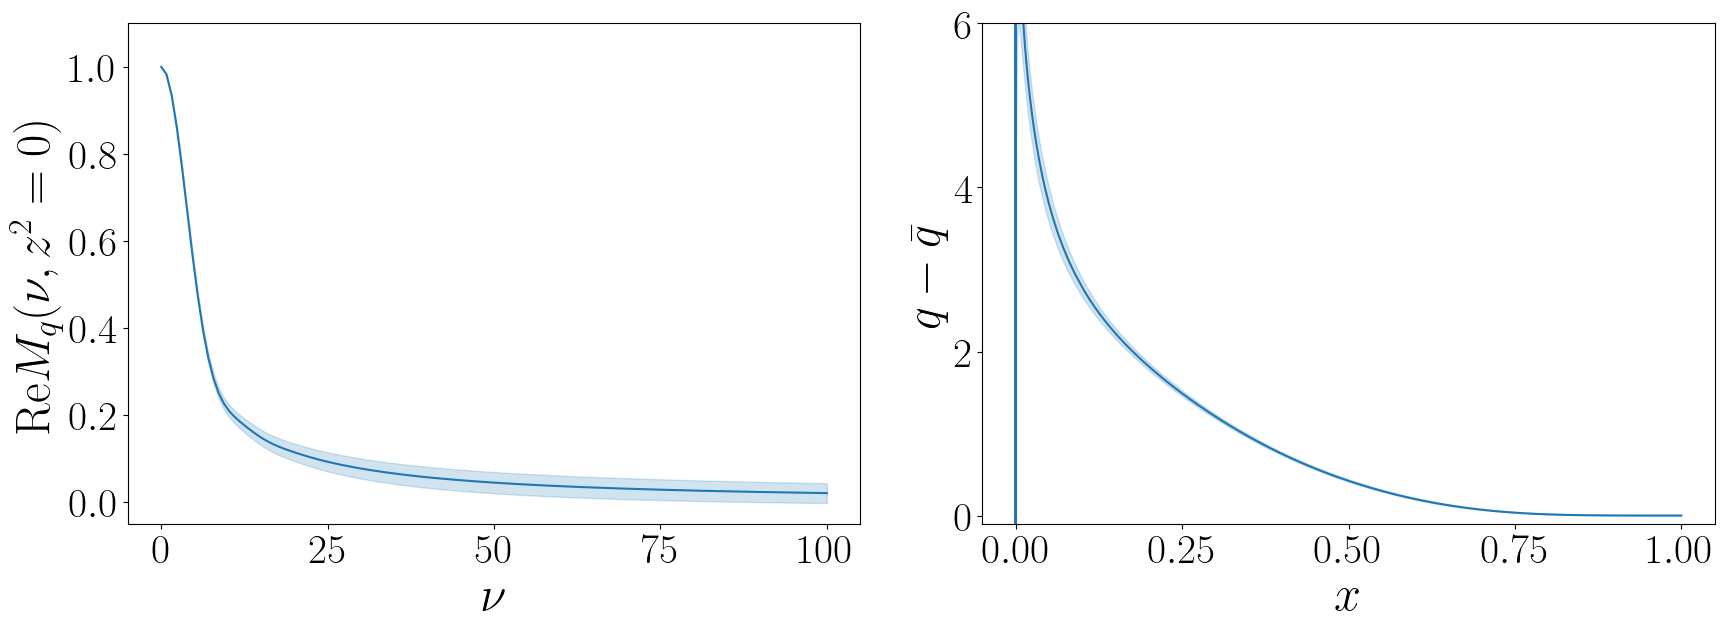

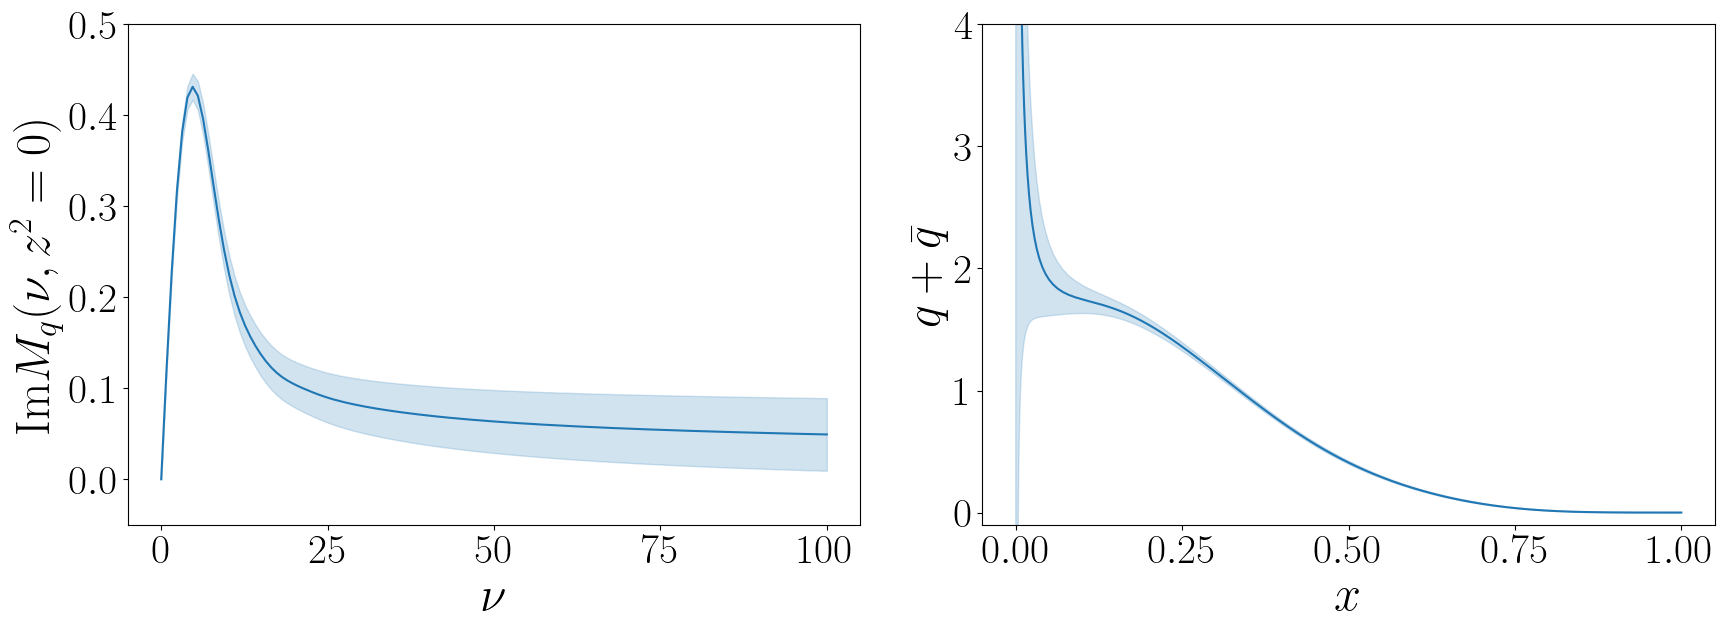

(<Figure size 1800x700 with 2 Axes>,
 array([<Axes: xlabel='$\\nu$', ylabel='Im$M_q(\\nu,z^2=0)$'>,
        <Axes: xlabel='$x$', ylabel='$q+\\bar{q}$'>], dtype=object))

In [ ]:
def plot_pdf_ITD(pdf,cov,iB,x_grid_orig,nn,ITD):
    #plot
    #mpl.rcParams["text.usetex"] = True 
    #plot pdf and ITD
    fci=1.95
    fig, ax = plt.subplots(1, 2, figsize=(18, 7))
    ax[1].plot(x_grid_orig,pdf,label="NNPDF")
    ax[1].fill_between(x_grid_orig, pdf-np.sqrt(np.diag(cov)), pdf+np.sqrt(np.diag(cov)), alpha=0.2,color='C0')
    #ax[1].fill_between(x_grid_orig, pdf-fci*np.sqrt(np.diag(cov)), pdf+fci*np.sqrt(np.diag(cov)), alpha=0.1,color='C0')
    ax[1].set_xlabel(r"$x$", fontsize=35)
    if ITD=="Re":
        ax[1].set_ylabel(r"$q-\bar{q}$", fontsize=35)
    else:
        ax[1].set_ylabel(r"$q+\bar{q}$", fontsize=35)
    if ITD=="Re":
        ax[1].set_ylim(-0.1,6)
        ax[0].set_ylim(-0.05,1.1)
    else:
        ax[1].set_ylim(-0.1,4)
        ax[0].set_ylim(-0.05,0.5)
    itd= iB @ pdf
    itdcov= iB @ cov @ iB.T
    ax[0].plot(nn,itd,label="NNPDF")
    ax[0].fill_between(nn, itd-np.sqrt(np.diag(itdcov)), itd+np.sqrt(np.diag(itdcov)), alpha=0.2,color='C0')
    #ax[0].fill_between(nn, itd-fci*np.sqrt(np.diag(itdcov)), itd+fci*np.sqrt(np.diag(itdcov)), alpha=0.1,color='C0')
    ax[0].set_xlabel(r"$\nu$", fontsize=35)
    ax[0].set_ylabel(rf"{ITD}$M_q(\nu,z^2=0)$", fontsize=35)
    plt.show()
    fig.savefig(f"NNPDF_data_{ITD}.pdf", bbox_inches='tight')
    return fig,ax
plot_pdf_ITD(pdf_re,cov_re,iB_re,x_grid_orig,nn,"Re")
plot_pdf_ITD(pdf_im,cov_im,iB_im,x_grid_orig,nn,"Im")

In [4]:
nmell=np.linspace(1,20,20)
print("nmell",nmell)

nmell [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]


In [5]:
#Mellin moments 
ntot=20
iBmell=np.zeros((ntot,x_grid_orig.shape[0]))
#if ITD=="Im":#0dd
for n in range(1,ntot+1):
#    print(rf"Mellin moments: $<x^{n}>_q$")
    iBmell[n-1,:] = fe_orig.set_up_integration(Kernel= lambda x : x**(n-1))
iBmellRe=iBmell[::2]
iBmellIm=iBmell[1::2]
        

In [6]:
#samples pdf times the mellin moments 
mellRe=iBmellRe@pdfminus[:,1:]
mellIm=iBmellIm@pdfplus[:,1:]
#mean and covariance
meanmellRe=mellRe.mean(axis=1)
meanmellIm=mellIm.mean(axis=1)
covmellRe=np.cov(mellRe)
covmellIm=np.cov(mellIm)
print("meanmellRe",covmellRe.shape)


meanmellRe (10, 10)


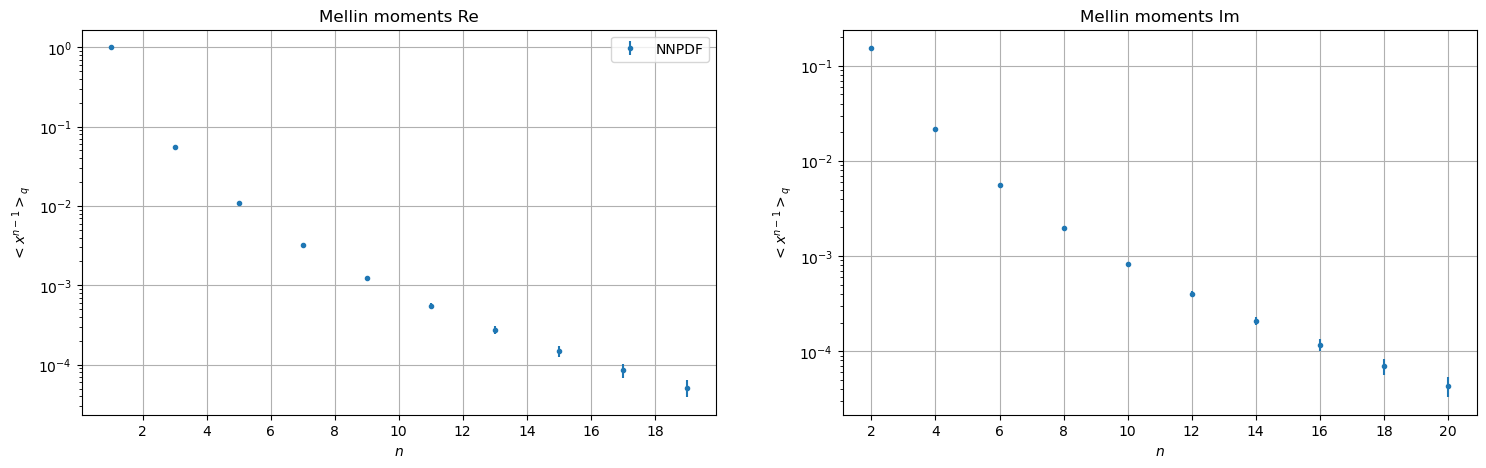

In [7]:
#plot
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
#plot with error bars
ax[0].set_title("Mellin moments Re")
ax[0].errorbar(nmell[::2],meanmellRe,yerr=np.sqrt(np.diag(covmellRe)), fmt='.', label='NNPDF')
ax[0].set_xlabel(r"$n$")
ax[0].set_ylabel(r"$<x^{n-1}>_q$")
#log grid
ax[0].set_yscale('log')
ax[1].set_title("Mellin moments Im")
ax[1].errorbar(nmell[1::2],meanmellIm,yerr=np.sqrt(np.diag(covmellIm)), fmt='.', label='NNPDF')
ax[1].set_xlabel(r"$n$")
ax[1].set_ylabel(r"$<x^{n-1}>_q$")
#log grid
ax[1].set_yscale('log')
ax[0].legend()
ax[0].grid()
ax[1].grid()
#print only integer numbers in x
ax[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

Text(0, 0.5, '$n$')

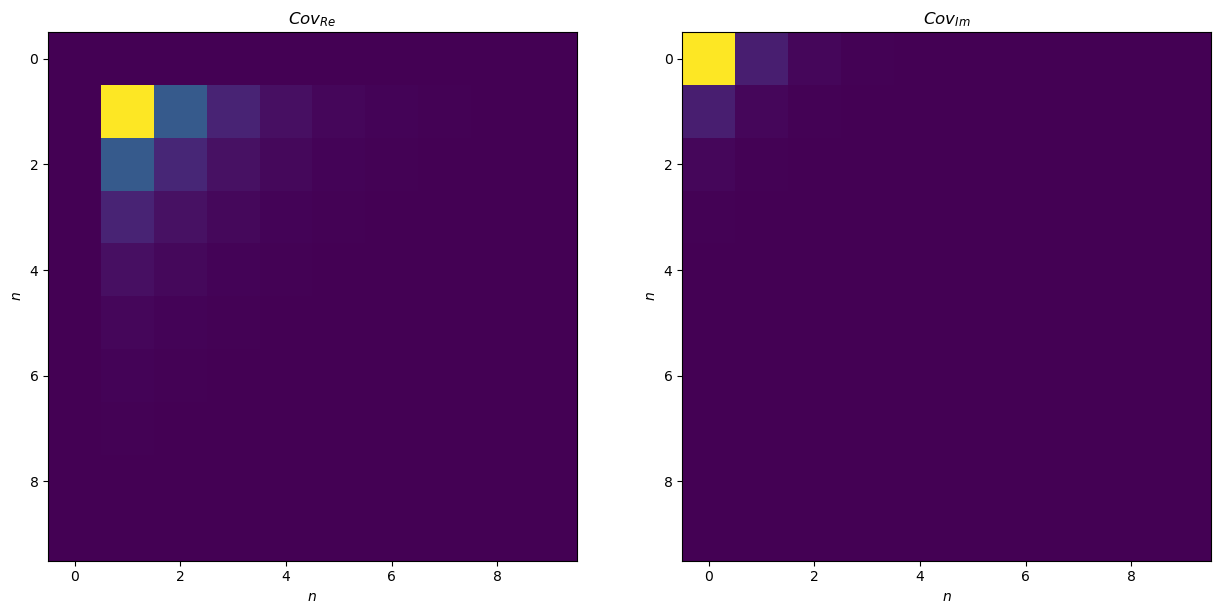

In [11]:
#plot covariances
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
#plot imshow
ax[0].imshow(covmellRe)
ax[0].set_title(r"$Cov_{Re}$")
ax[0].set_xlabel(r"$n$")
ax[0].set_ylabel(r"$n$")
ax[1].imshow(covmellIm)
ax[1].set_title(r"$Cov_{Im}$")
ax[1].set_xlabel(r"$n$")
ax[1].set_ylabel(r"$n$")

In [9]:
Nmell=mellRe.shape[0]
ITD="Re"
print("Nmell",Nmell,"ITD",ITD)
if ITD=="Re":#even integer
    nu_d_grid = np.linspace(0,2*Nmell,Nmell+1,dtype=int)
elif ITD=="Im":#odd
    nu_d_grid = np.linspace(1,2*Nmell-1,Nmell,dtype=int)

#print("numax: ",numax)
print("nu_d_grid: ",nu_d_grid)
#tranform to integer Mellin moments


Nmell 10 ITD Re
nu_d_grid:  [ 0  2  4  6  8 10 12 14 16 18 20]


In [10]:
iB1_re=np.zeros((nn.shape[0],x_grid.shape[0]))
iB1_im=np.zeros((nn.shape[0],x_grid.shape[0]))
fe=FE2_Integrator(x_grid)
for k in range(nn.shape[0]):
    iB1_re[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))
    iB1_im[k,:] = fe.set_up_integration(Kernel= lambda x : np.sin(nn[k]*x))

In [32]:
def NNPDFdatamell(mell,x_grid,lamb,ITD="Re",CP="odd"):
    
    
    Nmell=mell.shape[0]
    if ITD=="Re":#even integer
        n_grid = np.linspace(0,2*Nmell,Nmell+1,dtype=int)
    elif ITD=="Im":#odd
        n_grid = np.linspace(1,2*Nmell-1,Nmell,dtype=int)
    #print("n_grid",n_grid)
    Nx=x_grid.shape[0]
    M=mell.mean(axis=1)
    CovD=np.cov(mell)
    CovD=(CovD+CovD.T)/2.0

    regu= 1e-4*np.diag(np.diag(CovD))
    #CovD=np.abs(CovD)
    #print(M)
    fe = FE2_Integrator(x_grid)

    B0 = fe.set_up_integration(Kernel=lambda z: 1)#normalization
    B1 = np.zeros_like(B0) 
    B1[-1] = 1.0 # x=1 is at the end... #Delta function
    # is the nu values at current z
    B = np.zeros((Nmell,Nx))
    for k in range(Nmell):
        B[k,:] = fe.set_up_integration(Kernel= lambda x : x**(n_grid[k]))
    V = np.concatenate((B1[np.newaxis,:],B))
    Gamma = np.zeros((V.shape[0],V.shape[0]))
    Gamma[0,0] = lamb #delta function constraint
    Gamma[1:,1:] = CovD + regu
    Y = np.concatenate(([0.0],M))

    return x_grid,V,Y,Gamma

def NNPDFdatamix(mell,datanu,x_grid,lamb,ITD="Re"):
    nu_d_grid = datanu.T[1]
    numax=nu_d_grid.shape[0]
    
    Nmell=mell.shape[0]
    if ITD=="Re":#even integer
        n_grid = np.linspace(0,2*Nmell,Nmell+1,dtype=int)
    elif ITD=="Im":#odd
        n_grid = np.linspace(1,2*Nmell-1,Nmell,dtype=int)

    Nx=x_grid.shape[0]

    M=mell.mean(axis=1)
    CovD=np.cov(mell)
    CovD=(CovD+CovD.T)/2.0
    regu= 1e-4*np.diag(np.diag(CovD))
    #CovD=np.abs(CovD)

    Mnu=datanu.T[2:].mean(axis=0)
    eMnu=datanu.T[2:].std(axis=0)
    CovDnu=np.cov(datanu.T[2:].T)
    CovDnu=(CovDnu+CovDnu.T)/2.0
    regunu= 1e-4*np.diag(np.diag(CovDnu))


    fe = FE2_Integrator(x_grid)

    B0 = fe.set_up_integration(Kernel=lambda z: 1)#normalization
    B1 = np.zeros_like(B0) 
    B1[-1] = 1.0 # x=1 is at the end... #Delta function
    # is the nu values at current z
    B = np.zeros((Nmell,Nx))
    for k in range(Nmell):
        B[k,:] = fe.set_up_integration(Kernel= lambda x : x**(n_grid[k]))
    Bnu = np.zeros((numax,Nx))
    for k in range(numax):
        if ITD=="Re":
            Bnu[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nu_d_grid[k]*x))
        elif ITD=="Im":
            Bnu[k,:] = fe.set_up_integration(Kernel= lambda x : np.sin(nu_d_grid[k]*x))
    V = np.concatenate((B1[np.newaxis,:],B,Bnu))
    Gamma = np.zeros((V.shape[0],V.shape[0]))
    Gamma[0,0] = lamb #delta function constraint
    Gamma[1:Nmell+1,1:Nmell+1] = CovD + regu
    Gamma[1+Nmell:,1+Nmell:] = CovDnu + regunu
    Y = np.concatenate(([0.0],M,Mnu))

    return x_grid,V,Y,Gamma


nugget="no"
#lab = ['σ','l']
kernelname="Kdebbioxa"
modelname="PDF"
mode="kernel"
IDslurm="12"
grid="log_lin"
Nx=256
device="cpu"

mean,sigma,config,mod,ker,modfunc,kerfunc,device,mode,IDslurm,x_grid,lab=arguments(modelname,kernelname,nugget,device,mode,IDslurm,grid,Nx)

mellin_fitsRe=[]
mellin_fitsIm=[]
for i in range(2,4):
    x_grid,V,Y,Gamma = NNPDFdatamell(mellRe[0:i],x_grid,1e-3,ITD="Re")
    myGP0= GaussianProcess(x_grid,V,Y,Gamma,f"z=NNPDF_re(mell={mellRe[0:i].shape[0]})",nugget=nugget,device=device,ITD="Re",labels=lab,kernelname=kernelname,modelname=modelname,Pd=modfunc, Ker=kerfunc,Pd_args=mod,Ker_args=ker)
    myGP0.prior2ndlevel(mode,0.99,mean=mean,sigma=sigma,prior_mode=config)
    mellin_fitsRe.append(myGP0)
    print(mellin_fitsRe[-1].name, "done")
for i in range(2,5):
    x_grid,V,Y,Gamma = NNPDFdatamell(mellIm[0:i],x_grid,1e-3,ITD="Im")
    myGP0= GaussianProcess(x_grid,V,Y,Gamma,f"z=NNPDF_im(mell={mellIm[0:i].shape[0]})",nugget=nugget,device=device,ITD="Im",labels=lab,kernelname=kernelname,modelname=modelname,Pd=modfunc, Ker=kerfunc,Pd_args=mod,Ker_args=ker)
    myGP0.prior2ndlevel(mode,0.99,mean=mean,sigma=sigma,prior_mode=config)
    mellin_fitsIm.append(myGP0)
    print(mellin_fitsIm[-1].name, "done")



z=NNPDF_re(mell=2) done
z=NNPDF_re(mell=3) done
z=NNPDF_im(mell=2) done
z=NNPDF_im(mell=3) done
z=NNPDF_im(mell=4) done


In [48]:
nugget="no"
#lab = ['σ','l']
kernelname="Kdebbioxa"
modelname="PDF"
mode="kernel"
IDslurm="12"
grid="log_lin"
Nx=256
device="cpu"

mean,sigma,config,mod,ker,modfunc,kerfunc,device,mode,IDslurm,x_grid,lab=arguments(modelname,kernelname,nugget,device,mode,IDslurm,grid,Nx)

mellin_fitsRe=[]
mellin_fitsIm=[]
datanu4re = np.loadtxt('NNPDF/NNPDF40_nnlo_as_01180_1000_itd_real_numax4.dat',dtype=np.float64)
datanu4im = np.loadtxt('NNPDF/NNPDF40_nnlo_as_01180_1000_itd_imag_numax4.dat',dtype=np.float64)
for i in range(2,10):
    x_grid,V,Y,Gamma = NNPDFdatamix(mellRe[0:i],datanu4re,x_grid,1e-3,ITD="Re")
    myGP0= GaussianProcess(x_grid,V,Y,Gamma,rf"z=NNPDF_re(mell={mellRe[0:i].shape[0]}+v=4)",nugget=nugget,device=device,ITD="Re",labels=lab,kernelname=kernelname,modelname=modelname,Pd=modfunc, Ker=kerfunc,Pd_args=mod,Ker_args=ker)
    myGP0.prior2ndlevel(mode,0.99,mean=mean,sigma=sigma,prior_mode=config)
    mellin_fitsRe.append(myGP0)
    print(mellin_fitsRe[-1].name, "done")
for i in range(2,11):
    x_grid,V,Y,Gamma = NNPDFdatamix(mellIm[0:i],datanu4im,x_grid,1e-3,ITD="Im")
    myGP0= GaussianProcess(x_grid,V,Y,Gamma,rf"z=NNPDF_im(mell={mellIm[0:i].shape[0]}+v=4)",nugget=nugget,device=device,ITD="Im",labels=lab,kernelname=kernelname,modelname=modelname,Pd=modfunc, Ker=kerfunc,Pd_args=mod,Ker_args=ker)
    myGP0.prior2ndlevel(mode,0.99,mean=mean,sigma=sigma,prior_mode=config)
    mellin_fitsIm.append(myGP0)
    print(mellin_fitsIm[-1].name, "done")

/sciclone/home/yacahuanamedra/.conda/envs/gptorch/lib/python3.12/site-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


z=NNPDF_re(mell=2+v=4) done
z=NNPDF_re(mell=3+v=4) done
z=NNPDF_re(mell=4+v=4) done
z=NNPDF_re(mell=5+v=4) done
z=NNPDF_re(mell=6+v=4) done
z=NNPDF_re(mell=7+v=4) done
z=NNPDF_re(mell=8+v=4) done
z=NNPDF_re(mell=9+v=4) done
z=NNPDF_im(mell=2+v=4) done
z=NNPDF_im(mell=3+v=4) done
z=NNPDF_im(mell=4+v=4) done
z=NNPDF_im(mell=5+v=4) done
z=NNPDF_im(mell=6+v=4) done
z=NNPDF_im(mell=7+v=4) done
z=NNPDF_im(mell=8+v=4) done
z=NNPDF_im(mell=9+v=4) done
z=NNPDF_im(mell=10+v=4) done


In [49]:
def trainmodels(mellin_fits):
    for i in range(0,len(mellin_fits)):
        mellin_fits[i].train(1000,lr=1e-3,mode="mean",function="evidence")
        mellin_fits[i].train(1000,lr=1e-3,mode=mode,function="evidence")
        print(tr.tensor(mellin_fits[i].pd_args +mellin_fits[i].ker_args  + (mellin_fits[i].sig,)))

In [50]:
trainmodels(mellin_fitsRe)
trainmodels(mellin_fitsIm)

Training mean only z=NNPDF_re(mell=2+v=4)
Training kernel only z=NNPDF_re(mell=2+v=4)
tensor([-0.3068,  1.5346,  1.4386,  0.8016,  0.2733,  0.0322,  1.0000])
Training mean only z=NNPDF_re(mell=3+v=4)
Training kernel only z=NNPDF_re(mell=3+v=4)
tensor([-0.3095,  1.5378,  1.4316,  0.8059,  0.2770,  0.0513,  1.0000])
Training mean only z=NNPDF_re(mell=4+v=4)
Training kernel only z=NNPDF_re(mell=4+v=4)
tensor([-0.3071,  1.5524,  1.4412,  0.8708,  0.3109,  0.1079,  1.0000])
Training mean only z=NNPDF_re(mell=5+v=4)
Training kernel only z=NNPDF_re(mell=5+v=4)
tensor([-0.3113,  1.4826,  1.4466,  0.8124,  0.3057,  0.2681,  1.0000])
Training mean only z=NNPDF_re(mell=6+v=4)
Training kernel only z=NNPDF_re(mell=6+v=4)
tensor([-0.3470,  1.3975,  1.3149,  0.7597,  0.2987,  0.3967,  1.0000])
Training mean only z=NNPDF_re(mell=7+v=4)
Training kernel only z=NNPDF_re(mell=7+v=4)
tensor([-0.3587,  1.2703,  1.2097,  0.9287,  0.4034,  0.3427,  1.0000])
Training mean only z=NNPDF_re(mell=8+v=4)
Training k

In [22]:
#training 
for i in range(0,len(mellin_fitsIm)):
    mellin_fitsIm[i].hyperparametersvalues()

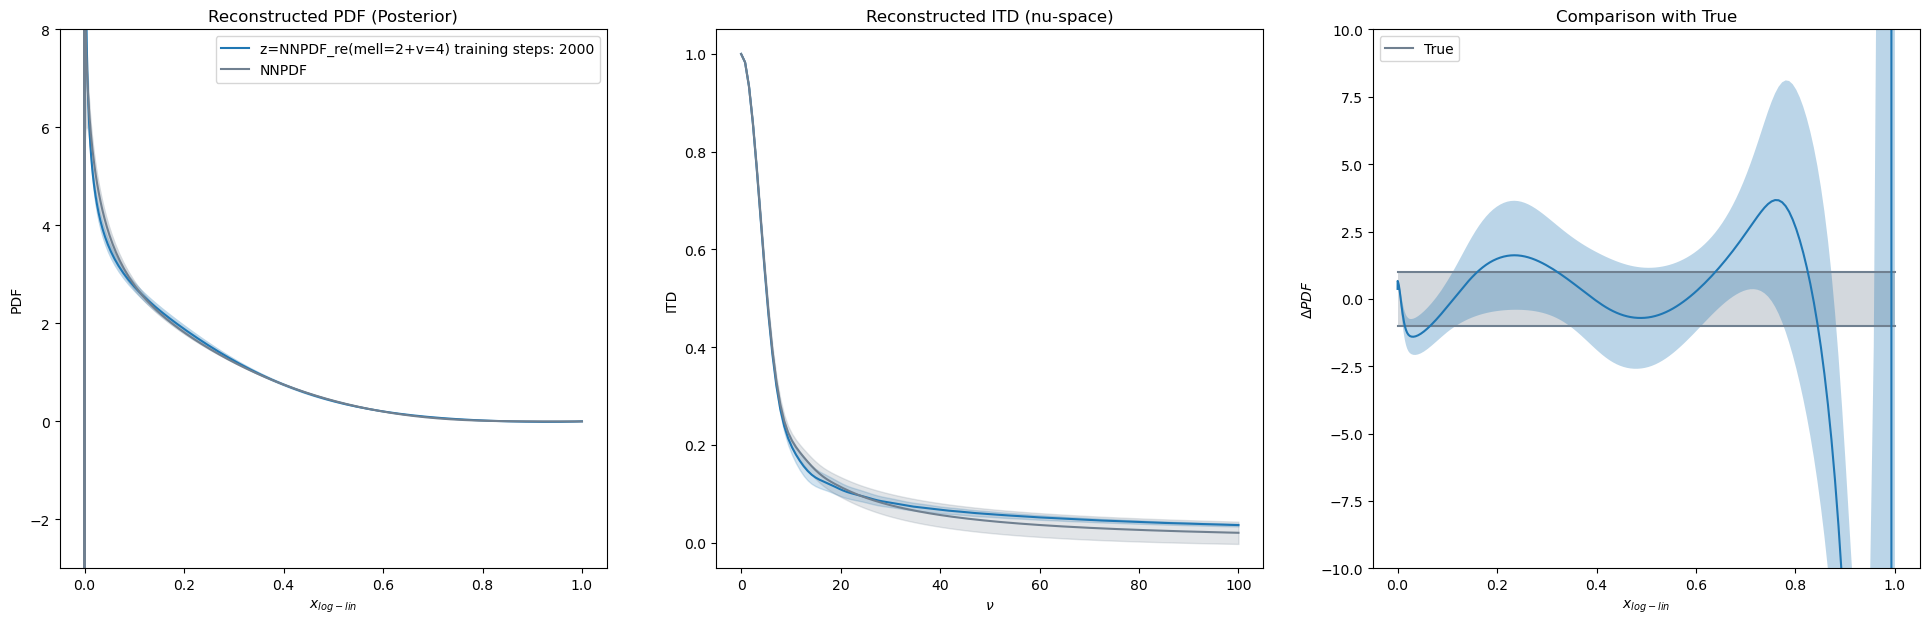

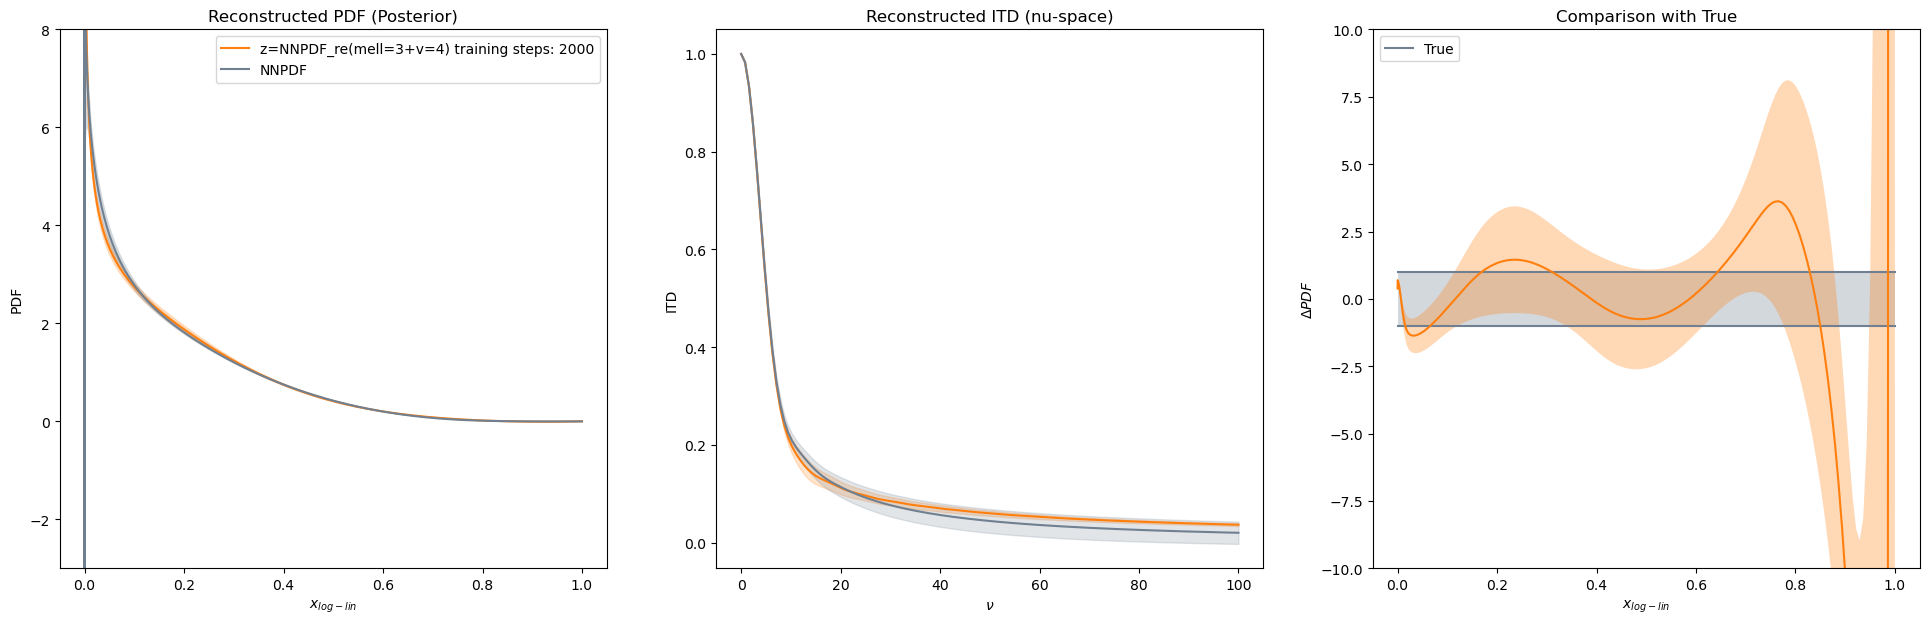

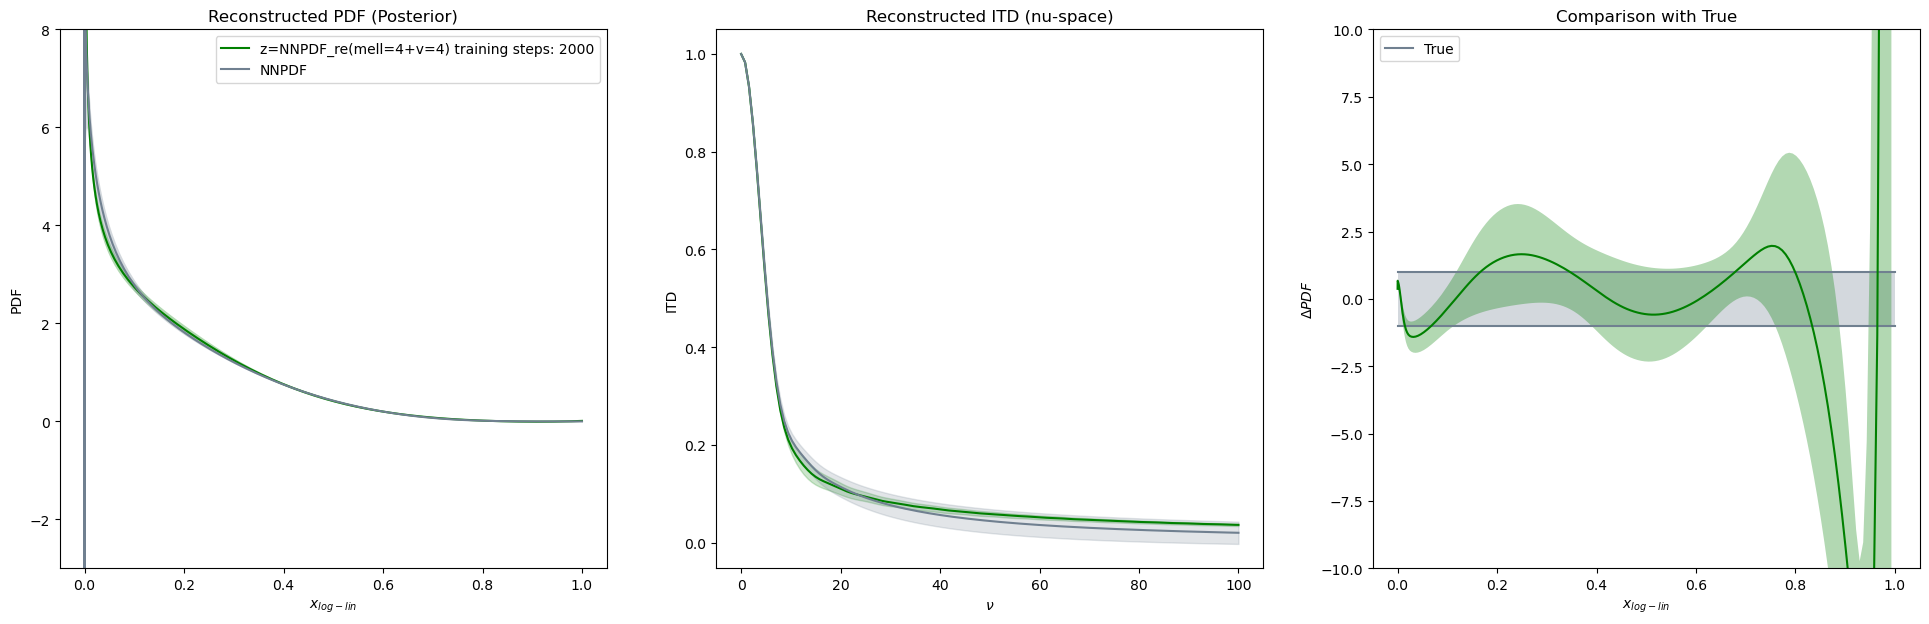

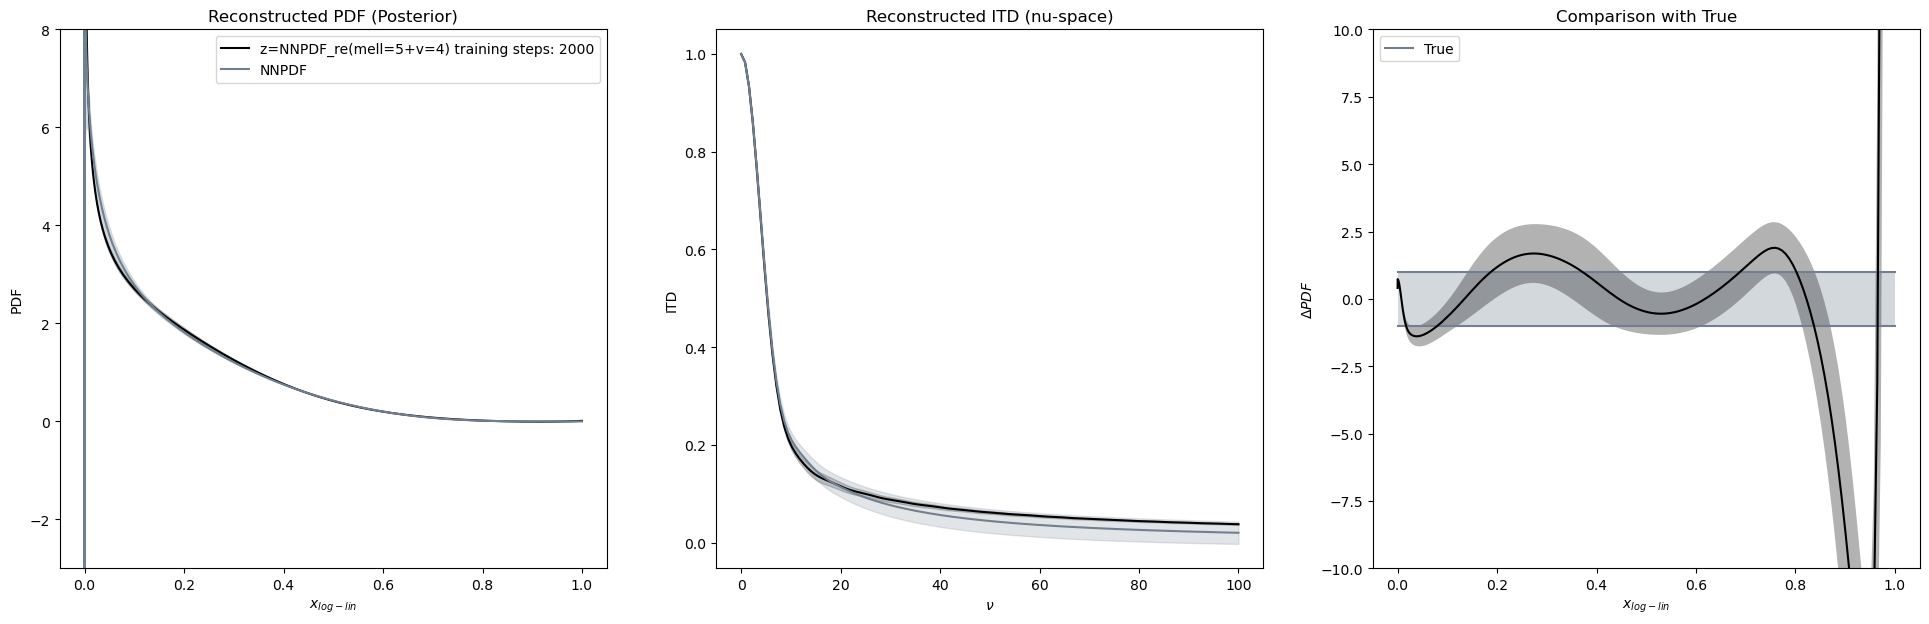

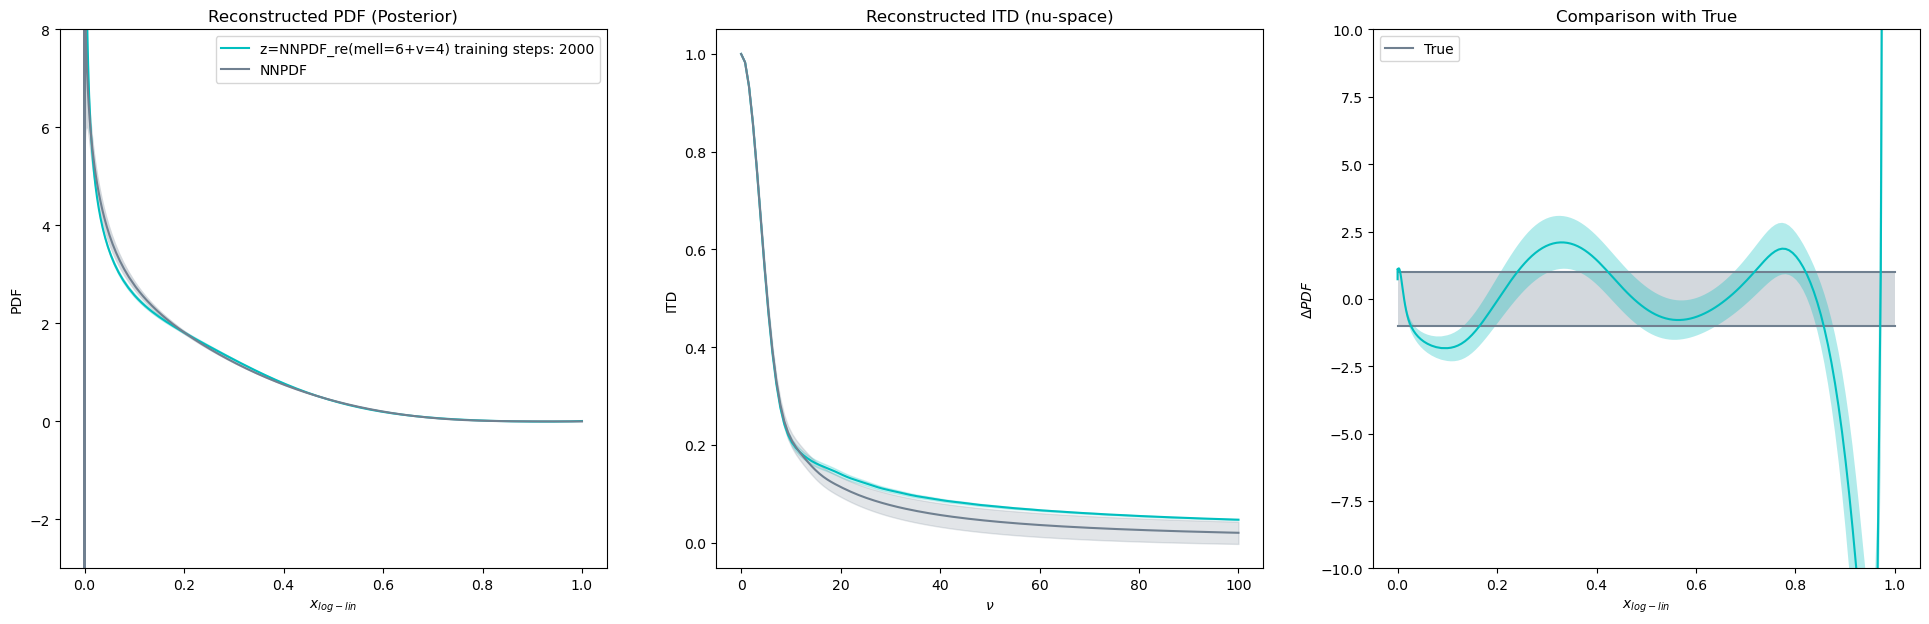

/local/scr/yacahuanamedra/TMPDIR/ipykernel_2251813/1016548109.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  pdfMc= np.random.multivariate_normal(p,Cp,(100,))


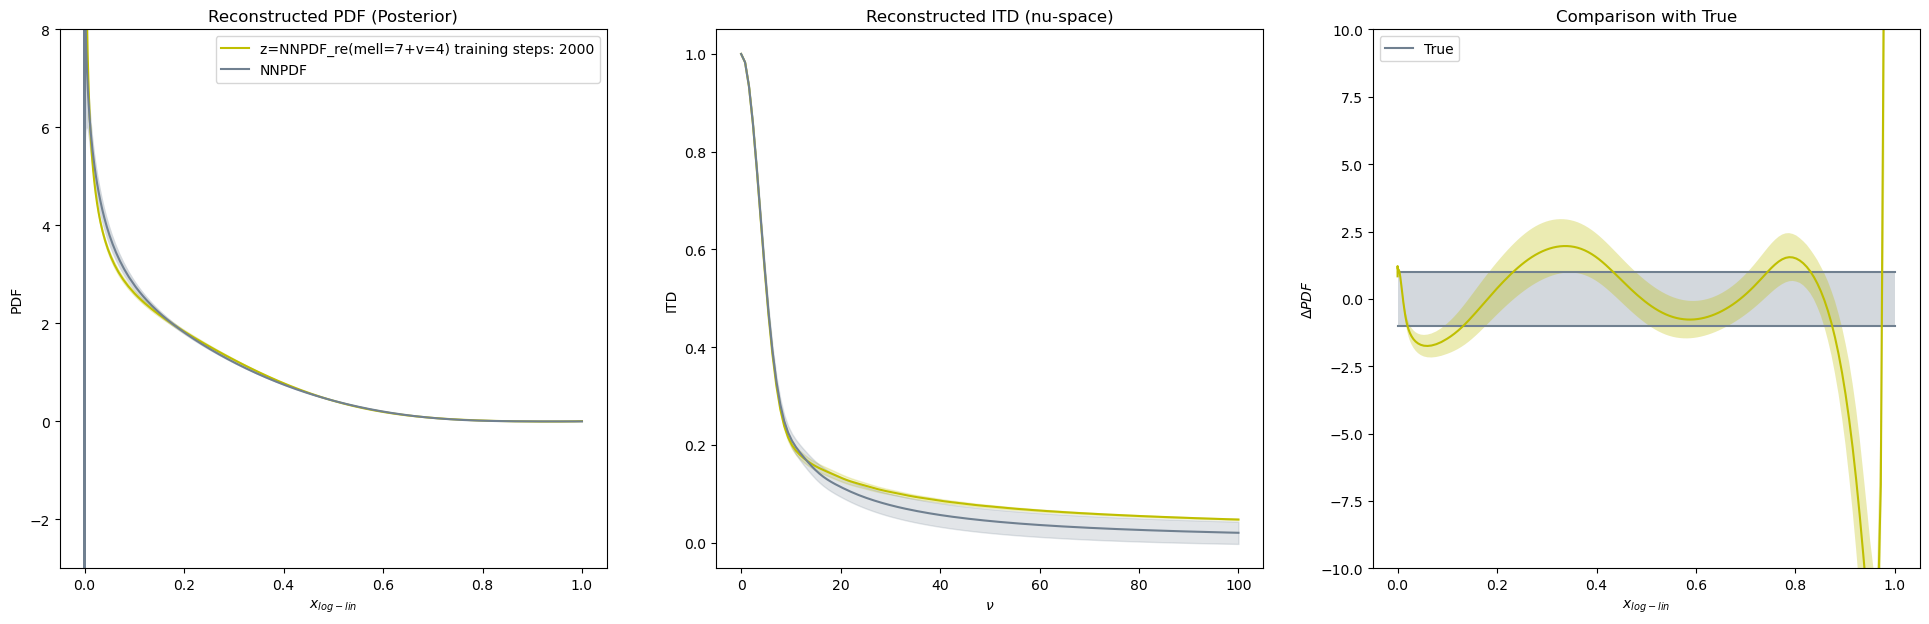

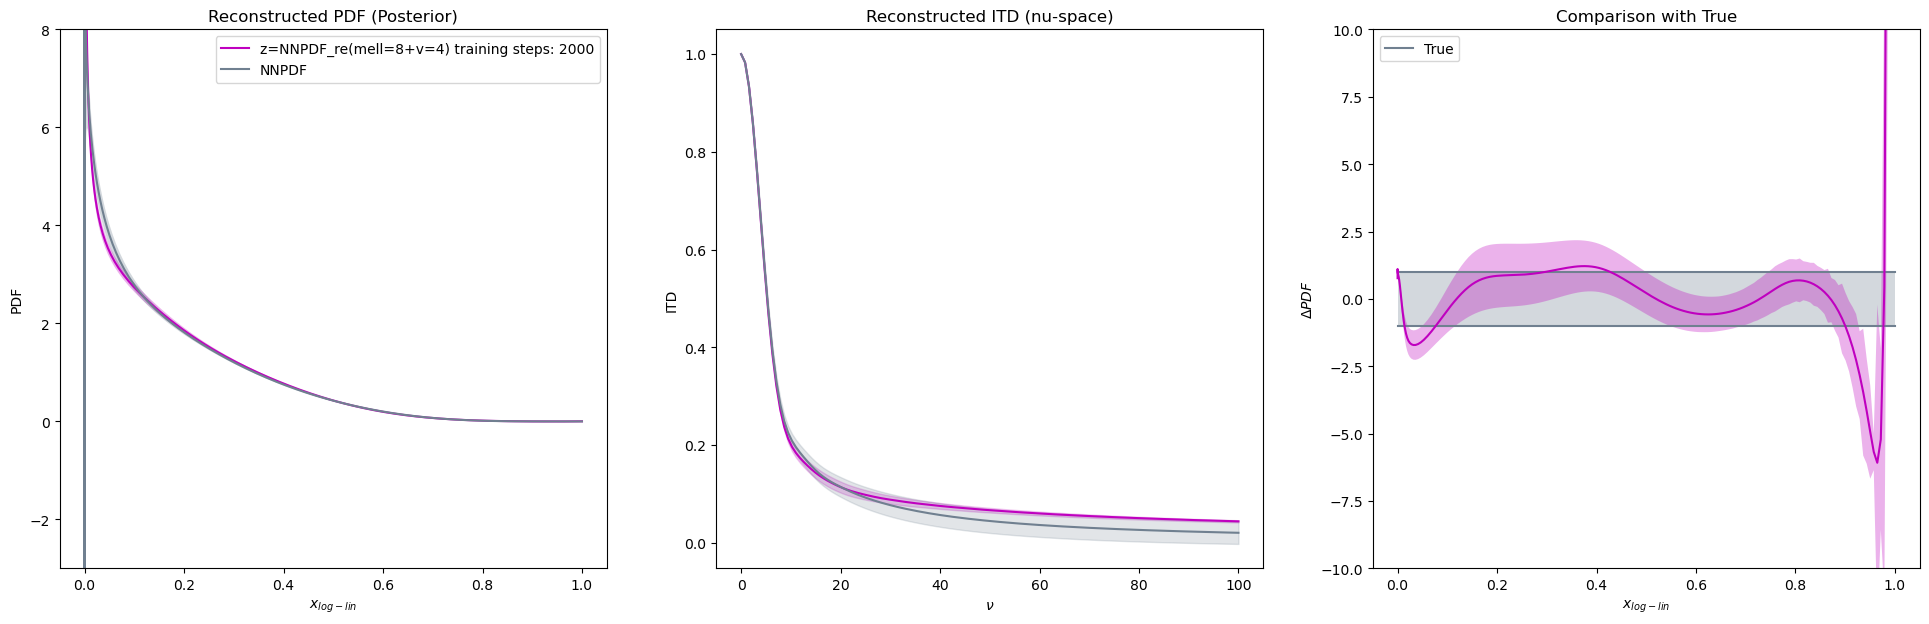

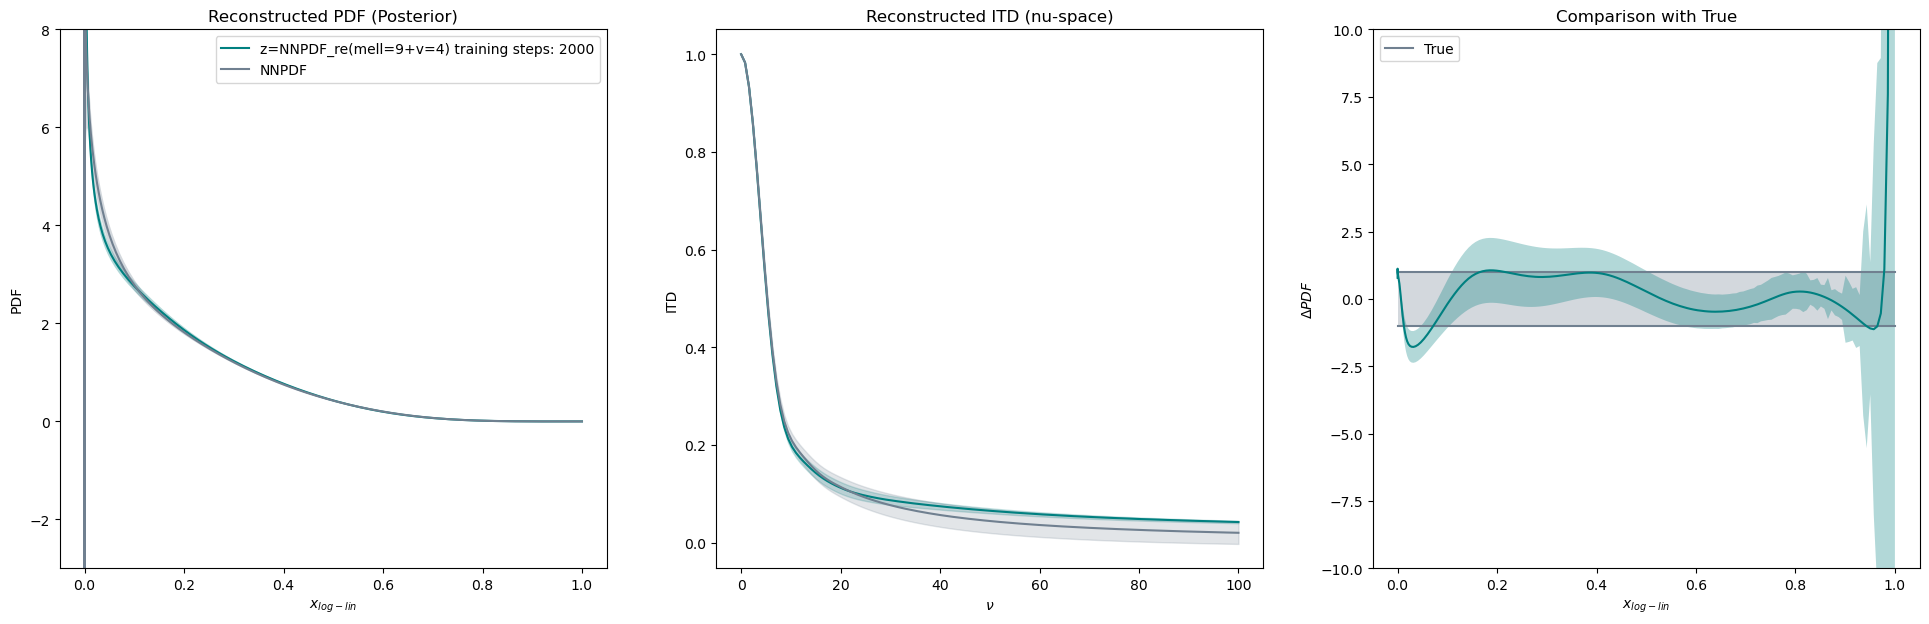

In [51]:
#col=['blue','green','orange','purple','brown','gray','black','lime','red']
def plot_mellin_fits(mellin_fits,x_grid,x_grid_orig,pdf,cov,iB1,iB,nn,pdf_interp,cov_interp):
    col=['tab:blue','tab:orange','g','k','c','y','m','teal','navy','coral','brown','yellowgreen','tan','slategrey']
    for i in range(0,len(mellin_fits)):
        fig, ax= plt.subplots(1,3,figsize=(24, 7))
        ax[0].set_title("Reconstructed PDF (Posterior)")
        ax[1].set_title("Reconstructed ITD (nu-space)")
        ax[2].set_title("Comparison with True")
        p,Cp = mellin_fits[i].ComputePosterior()
        p,Cp = p.to("cpu"),Cp.to("cpu")
        Cp = 0.5*(Cp+Cp.T) +1e-12*tr.eye(Cp.shape[0])

        #Mc=tr.distributions.MultivariateNormal(p,covariance_matrix=Cp)
        pdfMc= np.random.multivariate_normal(p,Cp,(100,))
        #plot the data
        #pdfMc = Mc.sample((100,))
        #ax[0].plot(x_grid,pdfMc.T,alpha=0.1,color=col[i])
        ax[0].plot(x_grid,p,label=mellin_fits[i].name+' training steps: '+str(mellin_fits[i].trainingcount),color=col[i])
        ax[0].plot(x_grid_orig,pdf,label="NNPDF",color=col[-1])
        perror=np.diag(np.abs(Cp))**(0.5)
        #p=fits_comb[i].Pd(fits_comb[i].x_grid.cpu(),*fits_comb[i].pd_args).numpy()
        ax[0].fill_between(x_grid, p - perror, p + perror, facecolor=col[i], alpha=0.3)
        ax[0].fill_between(x_grid_orig, pdf - np.sqrt(np.diag(cov)), pdf + np.sqrt(np.diag(cov)), facecolor=col[-1], alpha=0.3)
        ax[0].set_xlabel(r"$x_{log-lin}$")
        ax[0].set_ylabel(rf"PDF")

        ax[0].legend()
        ax[0].set_ylim([-3.,8])
        #ax[0].ylim([-0.1,4])
        ttQ = pdfMc@iB1.T
        itd_cov= iB1 @ Cp.numpy() @ iB1.T

        mttQ = ttQ.mean(axis=0)
        itd_re= iB @ pdf
        itdcov= iB @ cov @ iB.T

        #ax[1].plot(nn,ttQ.T,color=col[i],alpha=0.05)
        ax[1].fill_between(nn, mttQ-np.sqrt(np.diag(np.abs(itd_cov))), mttQ+np.sqrt(np.diag(np.abs(itd_cov))), alpha=0.2,color=col[i])
        ax[1].plot(nn,mttQ,color=col[i])
        ax[1].plot(nn,itd_re,label="NNPDF",color=col[-1])
        ax[1].fill_between(nn, itd_re-np.sqrt(np.diag(itdcov)), itd_re+np.sqrt(np.diag(itdcov)), alpha=0.2,color=col[-1])
        ax[1].set_xlabel(r"$\nu$")
        ax[1].set_ylabel(r"ITD")

        ax[2].plot(x_grid,-np.ones_like(x_grid),label="True",color=col[-1])
        ax[2].plot(x_grid,np.ones_like(x_grid),color=col[-1])
        ax[2].fill_between(x_grid, -np.ones_like(x_grid), np.ones_like(x_grid), facecolor=col[-1], alpha=0.3)
        #mean
        err=np.sqrt(cov_interp)
        Cp = Cp.numpy()
        p=p.numpy()
        ax[2].plot(x_grid,(p-pdf_interp)/err,color=col[i])
        ax[2].fill_between(x_grid, (p-pdf_interp)/err - np.sqrt(np.diag(np.abs(Cp)))/err, (p-pdf_interp)/err + np.sqrt(np.diag(np.abs(Cp)))/err, facecolor=col[i], alpha=0.3)
        ax[2].set_xlabel(r"$x_{log-lin}$")
        ax[2].set_ylabel(r"$\Delta PDF$")
        ax[2].set_ylim([-10,10])
        ax[2].legend()

        plt.show()
plot_mellin_fits(mellin_fitsRe,x_grid,x_grid_orig,pdf_re,cov_re,iB1_re,iB_re,nn,pdf_interp_re,cov_interp_re)


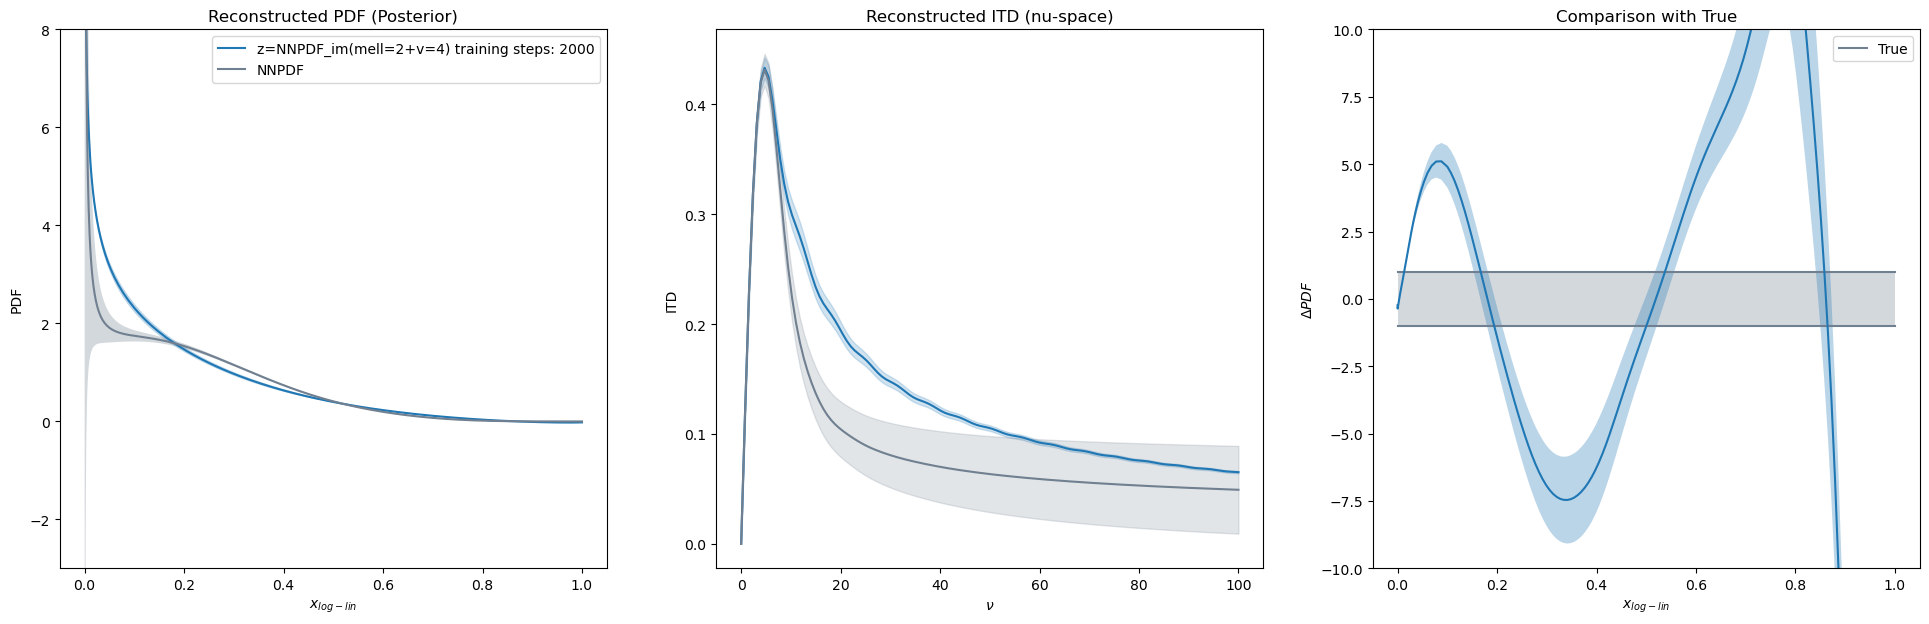

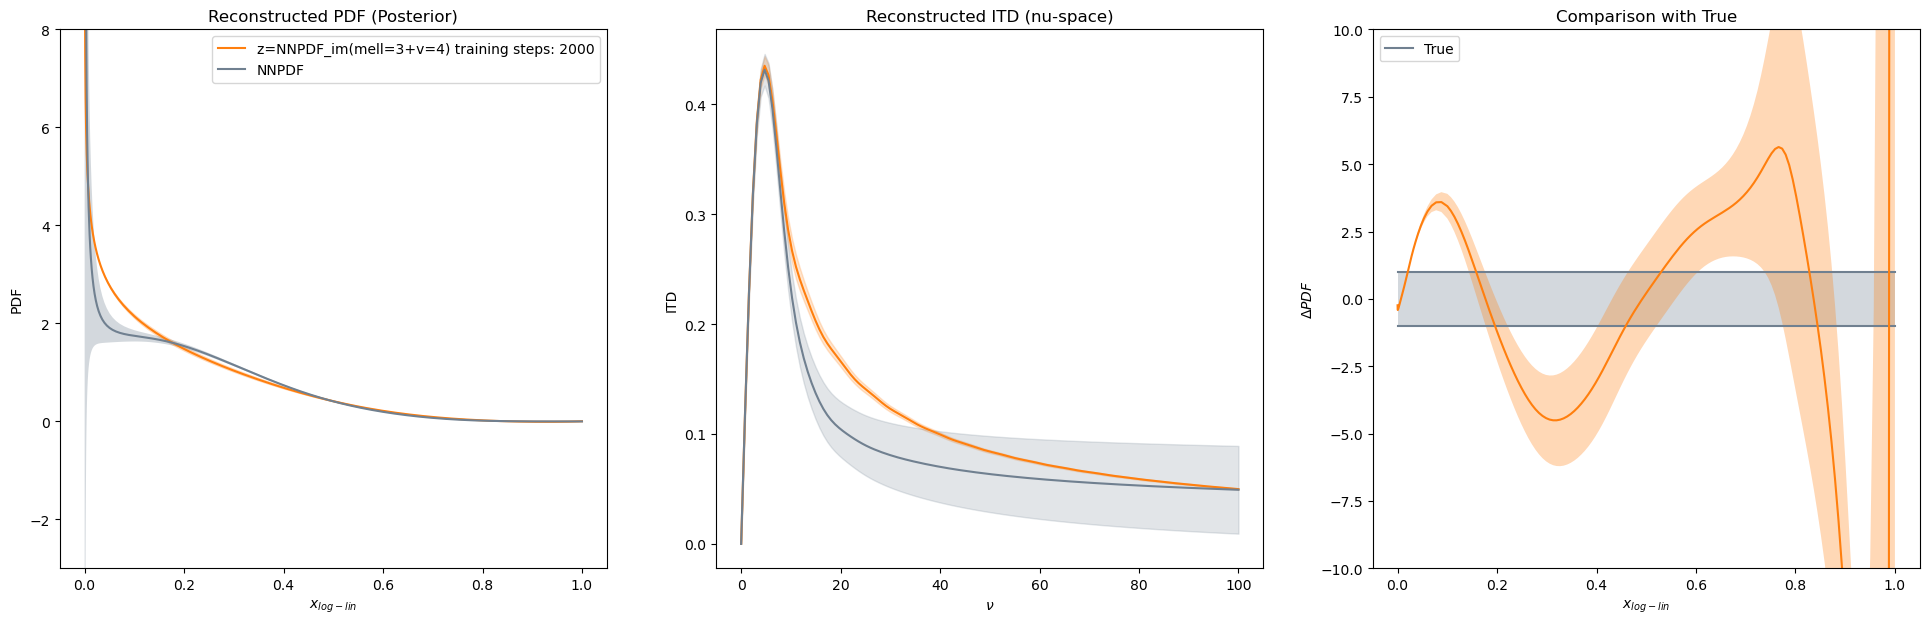

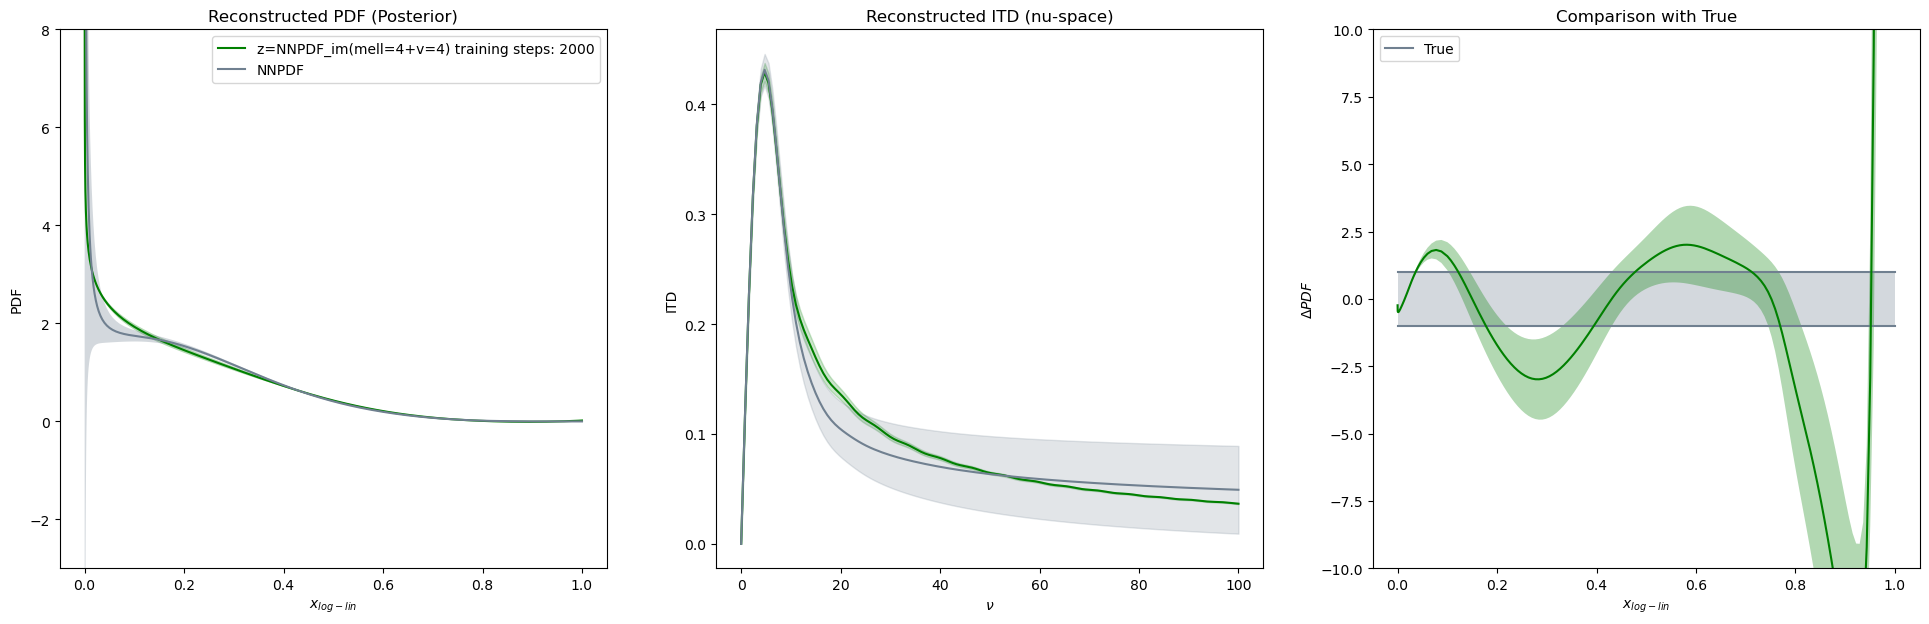

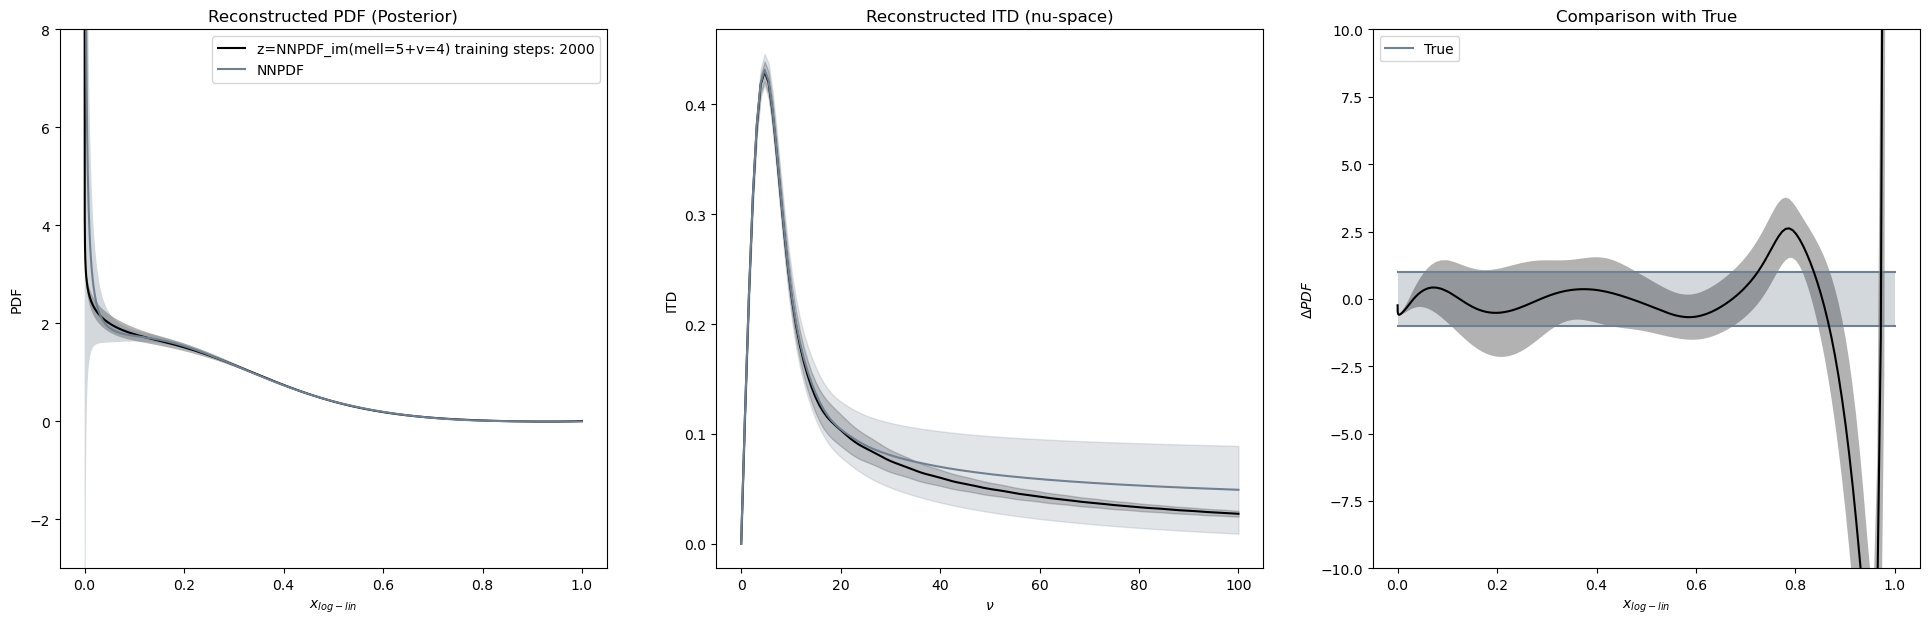

/local/scr/yacahuanamedra/TMPDIR/ipykernel_2251813/1016548109.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  pdfMc= np.random.multivariate_normal(p,Cp,(100,))


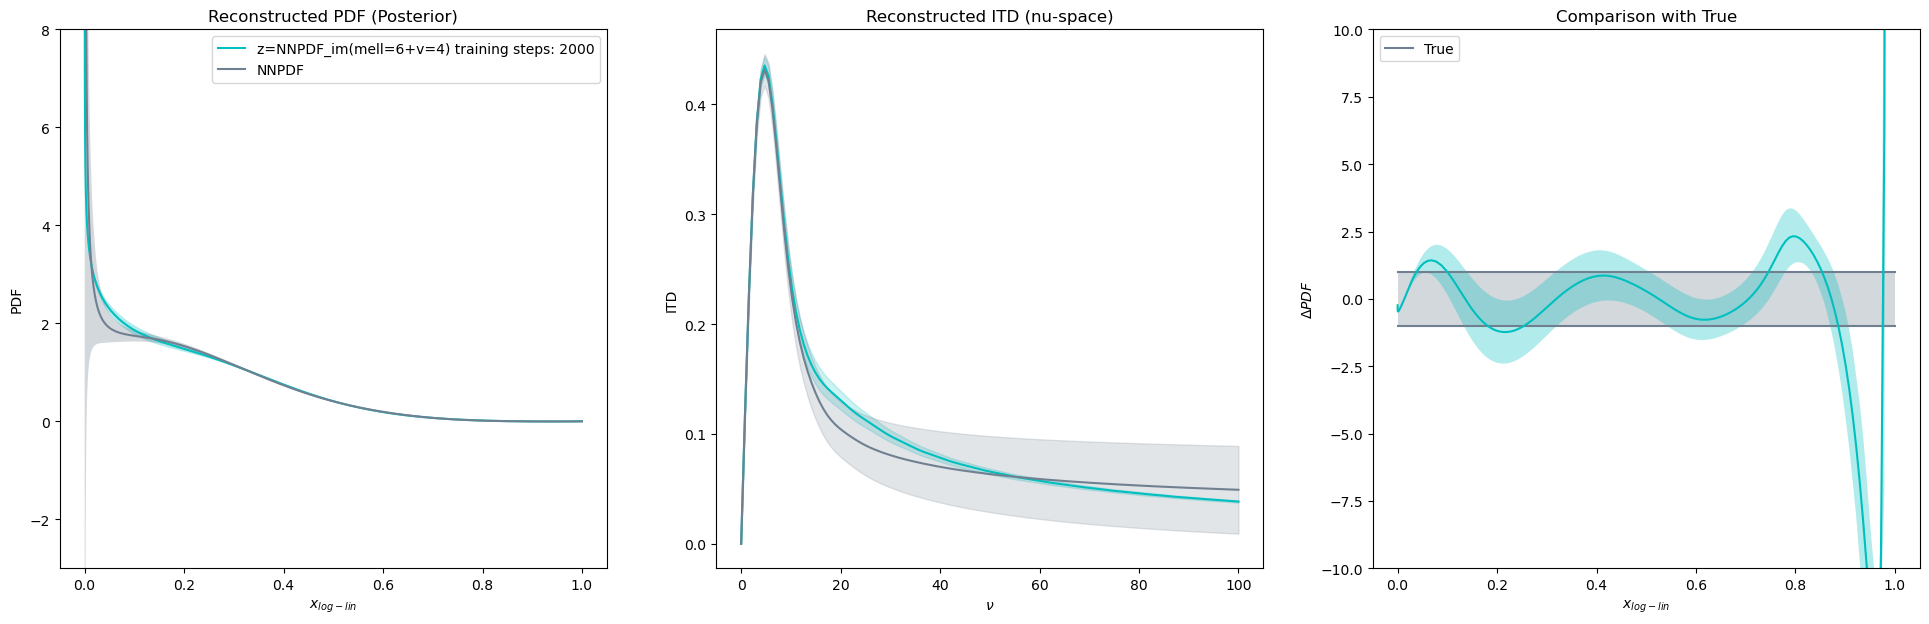

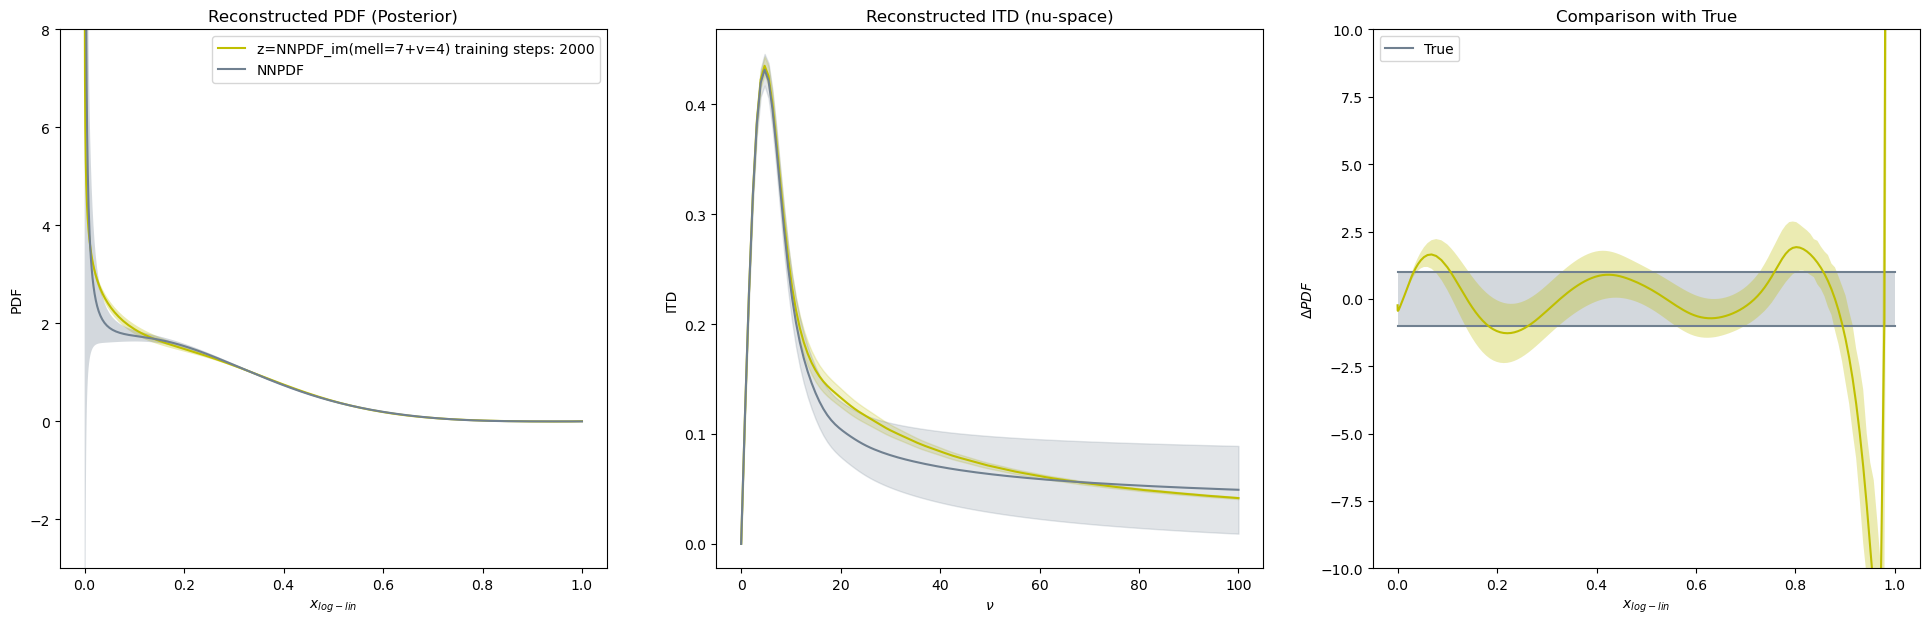

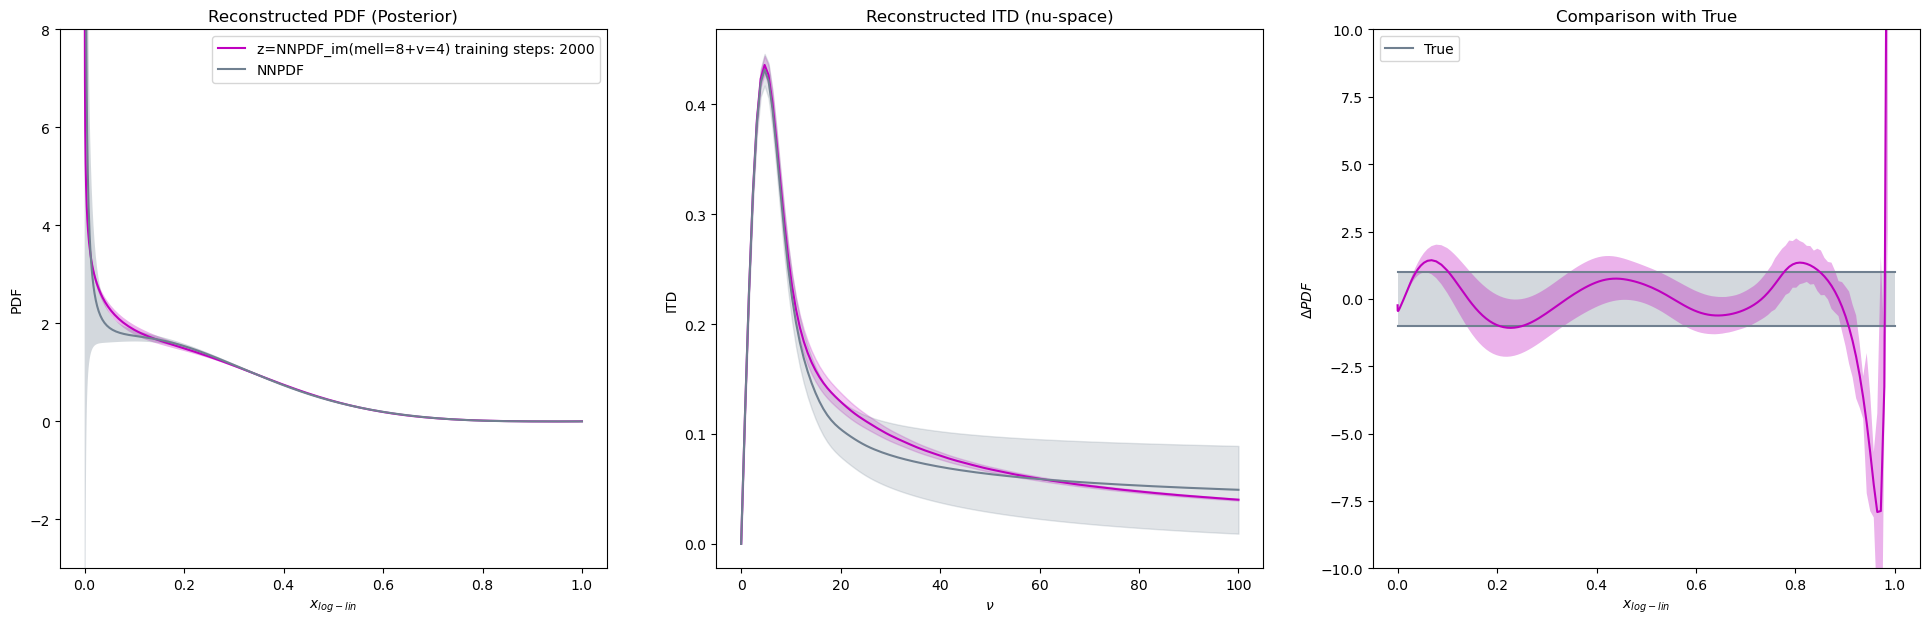

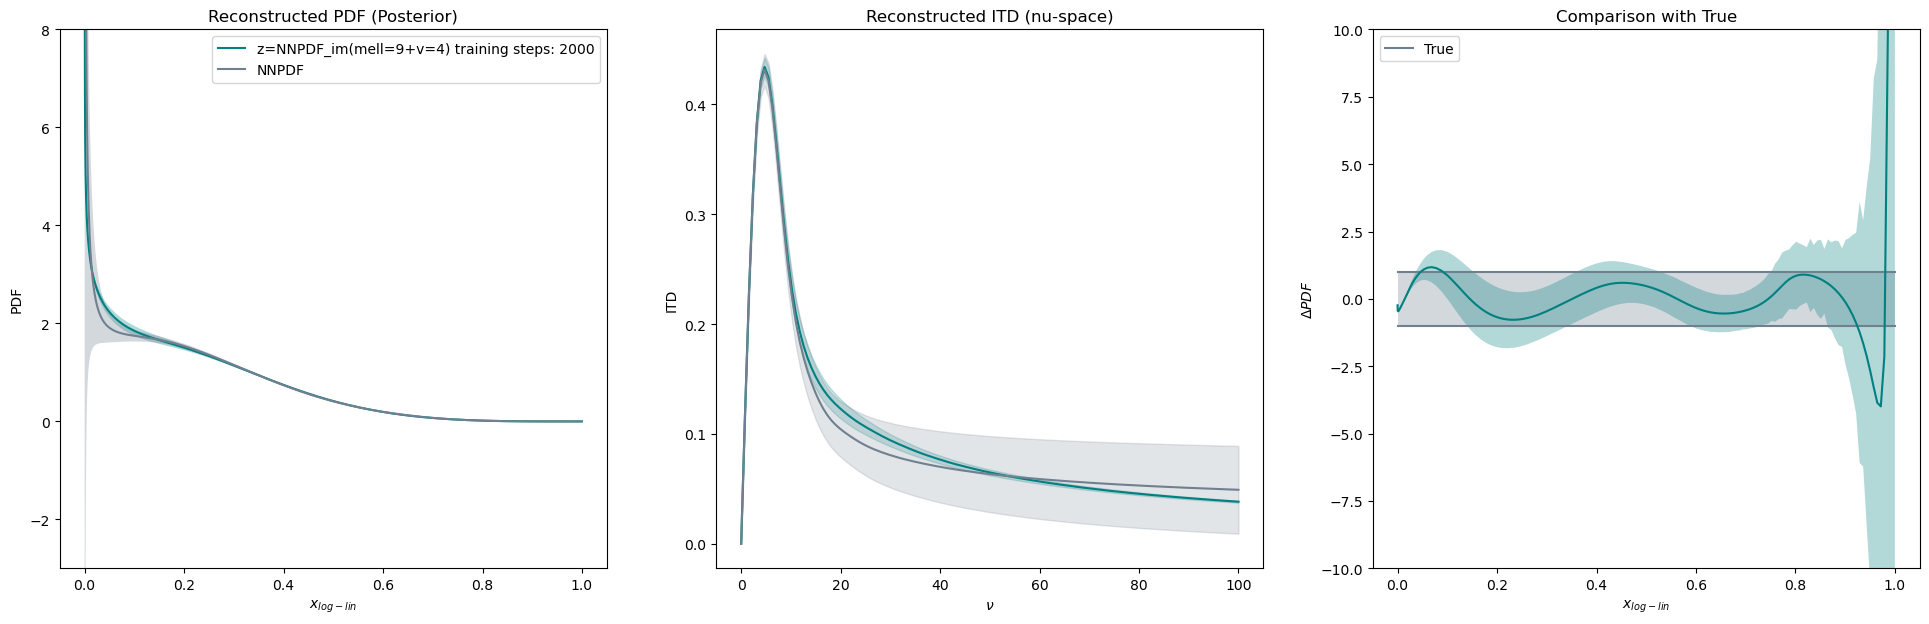

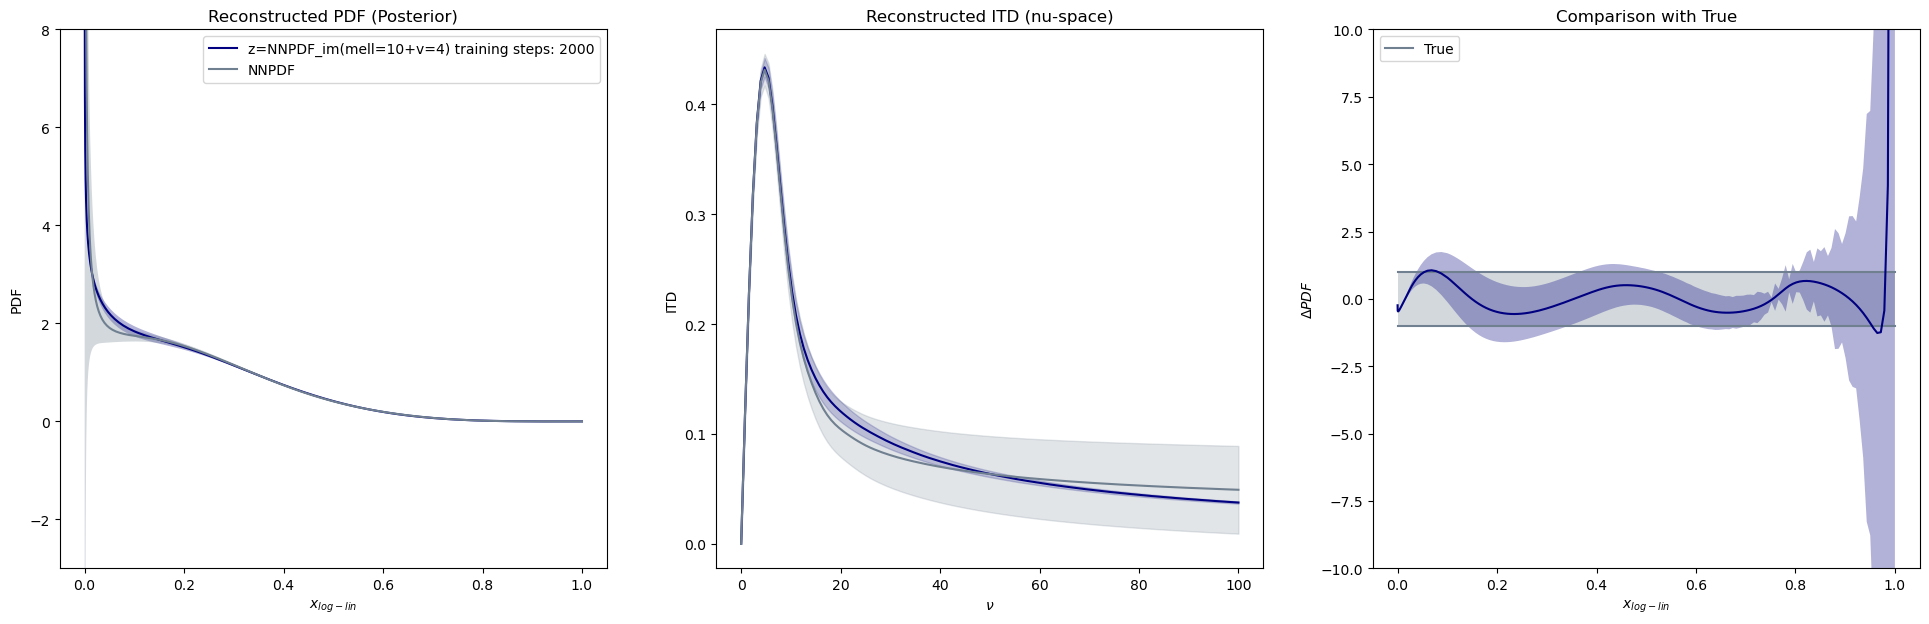

In [53]:
plot_mellin_fits(mellin_fitsIm,x_grid,x_grid_orig,pdf_im,cov_im,iB1_im,iB_im,nn,pdf_interp_im,cov_interp_im)

In [2]:
500000/32

15625.0

In [51]:
for i in range(0,len(mellin_fitsIm)):
    mellin_fitsIm[i].hyperparametersvalues()

In [43]:
#sampling
momentum=tr.ones_like(mean)
print(momentum)
GPsampler=HMC_sampler(myGP0.nlogpost2levelpdf,device="cpu",diagonal=1.0*momentum,grad=None)
GPsampler.q0=tr.tensor(myGP0.ker_args).to("cpu")

tensor([1., 1., 1., 1., 1.])


In [106]:
traceq,tracep,traceH=GPsampler.sample(GPsampler.q0,1000,1.0/1000,200)

  0%|                                                                          | 0/999 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████| 999/999 [15:37<00:00,  1.07it/s]
accepted: 1821
rejected: 0
acceptance rate: 1.0
total samples: 1821


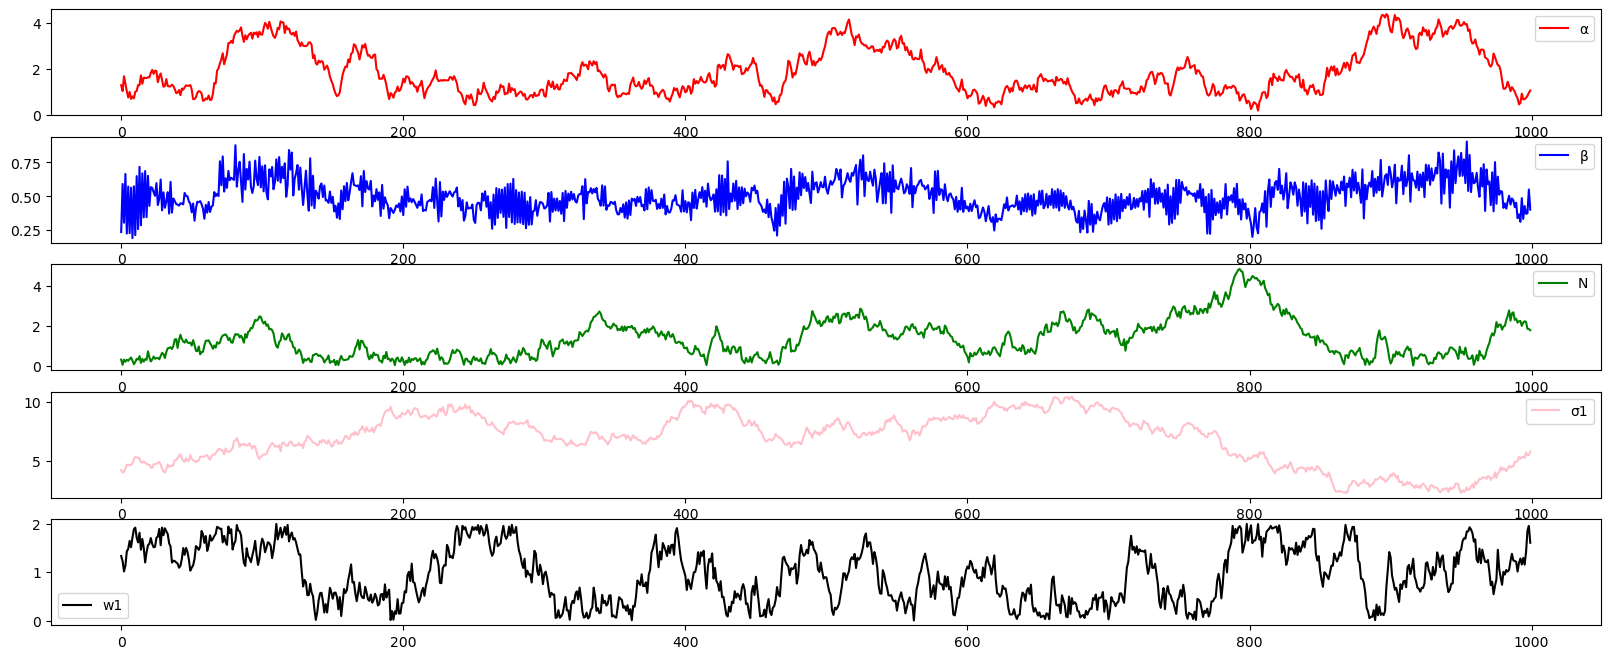

In [107]:
plotrace(traceq[0:1000].cpu(),0,kernel='splitrbf')